# Sentinel - hub

I am not gona lie. The [sentinel-hub repo](https://github.com/sentinel-hub/sentinelhub-py/tree/master/examples) has multiple examples. I do not find the right solution but all notebboks and script are very useful. 

## Problems


### Credentials

In order to perform the requests we need the authentication. You just need to sign up in https://services.sentinel-hub.com/oauth/subscription

### Get a bbox

In order to perform the request we need to generate a bbox. And we use http://bboxfinder.com/ 

### Working with geometries instead of bbox

The sentinel hub works with bounding boxes (bbox) theoretically, but when we talk about geometries that not a proper geometry so we cannot perform easy operations in shapely. --> i found after some digging that behind the scenes the packages uses shapely objects so it works with geometries at the end. `sentinelhub.geometry.BBox`

### Larger area request 

There are some limit i our case there are a 2500 px limit per request. Sentinel has a batch proccess but is only for comercial purpose (not in open data). So we have to *explode* this bbox gemetries and then make some request. 

*Note that also our free account has a limit per minute/day request so larger files cannot be archive in a efficient way.*

### Some selected zones does not habe all bands available 

So i have to change the bbox.  

### Problems with the factor and colors

I don't know much about ruster and images but the colors of outputs were yelow or black. I foudn some examples in the https://docs.sentinel-hub.com/api/latest/evalscript/v3/ that describes the proccess to convert it to images and true colors. 

In [1]:
from sentinelhub import SHConfig

config = SHConfig()
config.sh_client_id = '5db8f309-9bff-48f4-84f1-2396925ed8df'
config.sh_client_secret = '@zE?gXy*{!>AxwPW*.w(Ze98#6^+%9L&er(wQU!.'
if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

/Users/eve/opt/anaconda3/envs/unav00/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np

from shapely.geometry import MultiLineString, MultiPolygon, Polygon, shape

from sentinelhub import (
    CRS,
    BBox,
    BBoxSplitter,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)


import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as plt_polygon
from mpl_toolkits.basemap import Basemap  # Available here: https://github.com/matplotlib/basemap
# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
# from utils import plot_image

In [4]:
from typing import Any, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np


def plot_image(
    image: np.ndarray, factor: float = 1.0, clip_range: Optional[Tuple[float, float]] = None, **kwargs: Any
) -> None:
    """Utility function for plotting RGB images."""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])


## BBOX select 

In [35]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import bs4
from bs4 import BeautifulSoup
from html.parser import HTMLParser
import time

def get_bound_box(bypass = False):
    '''It opens a browser, navigates to a website, waits for the website to load, and then scrapes the
    bounding box coordinates from the website.  You have 2 minutes. If bypass == True then fixed value. 
    
    Returns
    -------
        A string of the bounding box coordinates
    
    '''
    bbox = '-4.011957,36.645068,-3.672754,36.862927'
    if not bypass:
        timeout = time.time() +  60 * 2 # to mins timeout
        options = Options()
        # options.add_experimental_option("detach", True)
        # options.add_experimental_option("excludeSwitches", ["enable-automation"])
        driver = webdriver.Chrome(options=options)
        url = "http://bboxfinder.com/#0.000000,0.000000,0.000000,0.000000"
        driver.get(url)
        time.sleep(3)
        html = driver.page_source
        soup = BeautifulSoup(html, 'html.parser')
        cont_w = True 
        while (cont_w and (time.time() < timeout)):
            if len(soup.find('span', attrs={'id':'boxbounds'}).contents) > 0:
                html = driver.page_source
                soup = BeautifulSoup(html, 'html.parser')
                bbox = soup.find('span', attrs={'id':'boxbounds'}).contents[0]
                if bbox != '0.000000,0.000000,0.000000,0.000000':
                    cont_w = False
        driver.close()
    return bbox

In [6]:
import io
from PIL import Image


def save_image(name,numpy_image,factor,clip):
    '''It takes a numpy array and saves it as an image
    
    Parameters
    ----------
    name
        The name of the image you want to save.
    numpy_image
        The image you want to save.
    
    Returns
    -------
        the value of True.
    
    '''
    convert = np.clip(numpy_image * factor,*clip)
    image = Image.fromarray(numpy_image, 'RGB')
    image.save(f"{name}.jpeg")
    return True

This is a way to plot the split bbox 

In [7]:
def show_splitter(splitter, alpha=0.2, area_buffer=0.2, show_legend=False):
    '''It takes a splitter object and plots the area and the tiles
    
    Parameters
    ----------
    splitter
        The splitter object that we created above.
    alpha
        The transparency of the tile.
    area_buffer
        The amount of extra space to add around the area.
    show_legend, optional
        If True, a legend will be shown with the tile names.
    
    '''
    area_bbox = splitter.get_area_bbox()
    minx, miny, maxx, maxy = area_bbox
    lng, lat = area_bbox.middle
    w, h = maxx - minx, maxy - miny
    minx = minx - area_buffer * w
    miny = miny - area_buffer * h
    maxx = maxx + area_buffer * w
    maxy = maxy + area_buffer * h

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    base_map = Basemap(
        projection="mill",
        lat_0=lat,
        lon_0=lng,
        llcrnrlon=minx,
        llcrnrlat=miny,
        urcrnrlon=maxx,
        urcrnrlat=maxy,
        resolution="l",
        epsg=4326,
    )
    base_map.drawcoastlines(color=(0, 0, 0, 0))

    area_shape = splitter.get_area_shape()

    if isinstance(area_shape, Polygon):
        polygon_iter = [area_shape]
    elif isinstance(area_shape, MultiPolygon):
        polygon_iter = area_shape.geoms
    else:
        raise ValueError(f"Geometry of type {type(area_shape)} is not supported")

    for polygon in polygon_iter:
        if isinstance(polygon.boundary, MultiLineString):
            for linestring in polygon.boundary:
                ax.add_patch(plt_polygon(np.array(linestring), closed=True, facecolor=(0, 0, 0, 0), edgecolor="red"))
        else:
            ax.add_patch(
                plt_polygon(np.array(polygon.boundary.coords), closed=True, facecolor=(0, 0, 0, 0), edgecolor="red")
            )

    bbox_list = splitter.get_bbox_list()
    info_list = splitter.get_info_list()

    cm = plt.get_cmap("jet", len(bbox_list))
    legend_shapes = []
    for i, (bbox, info) in enumerate(zip(bbox_list, info_list)):
        wgs84_bbox = bbox.transform(CRS.WGS84).get_polygon()

        tile_color = tuple(list(cm(i))[:3] + [alpha])
        ax.add_patch(plt_polygon(np.array(wgs84_bbox), closed=True, facecolor=tile_color, edgecolor="green"))

        if show_legend:
            legend_shapes.append(plt.Rectangle((0, 0), 1, 1, fc=cm(i)))

    if show_legend:
        legend_names = []
        for info in info_list:
            legend_name = "{},{}".format(info["index_x"], info["index_y"])

            for prop in ["grid_index", "tile"]:
                if prop in info:
                    legend_name = "{},{}".format(info[prop], legend_name)

            legend_names.append(legend_name)

        plt.legend(legend_shapes, legend_names)
    plt.tight_layout()
    plt.show()

In [8]:
def show_area(area_shape, area_buffer=0.3):
    '''It takes a shapely polygon or multipolygon and plots it on a map
    
    Parameters
    ----------
    area_shape
        the shape of the area you want to plot
    area_buffer
        This is the buffer around the area that we want to include in the query.
    
    '''
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    minx, miny, maxx, maxy = area_shape.bounds
    lng, lat = (minx + maxx) / 2, (miny + maxy) / 2

    m = Basemap(projection="lcc", lat_0=lat, lon_0=lng, resolution="l", width=1.05E6, height=1.2E6)
    m.drawcoastlines()
    m.bluemarble()

    if isinstance(area_shape, Polygon):
        polygon_iter = [area_shape]
    elif isinstance(area_shape, MultiPolygon):
        polygon_iter = area_shape.geoms
    else:
        raise ValueError(f"Geometr of type {type(area_shape)} is not supported")

    for polygon in polygon_iter:
        x, y = np.array(polygon.boundary.coords)[0]
        m_poly = []
        for x, y in np.array(polygon.boundary.coords):
            m_poly.append(m(x, y))
        ax.add_patch(plt_polygon(np.array(m_poly), closed=True, facecolor=None, edgecolor="red",fill = False))

    plt.tight_layout()
    plt.show()


## Sentinel Request

In [9]:
evalscript = """
function setup() {
    return {
      input: [{
          bands: ["B02", "B03", "B04", "B08"],
          units: ["reflectance", "reflectance", "reflectance", "DN"] // B08 will be in digital numbers, the rest reflectance
      }],
      output: [{ // this is now an array since there are multiple output objects
          id: "rgb"
          bands: 3
      }, {
          id: "falseColor"
          bands: 3
      }]
    }
}
"""

In [10]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

In [22]:
def generate_request(bbox):
    '''> The function takes a bounding box and returns a request object that can be used to download a true
    color image from Sentinel-2
    
    Parameters
    ----------
    bbox
        The bounding box of the area you want to download.
    
    Returns
    -------
        A request object
    
    '''
    
    betsiboka_bbox = bbox
    betsiboka_size = bbox_to_dimensions(betsiboka_bbox, resolution=resolution)
    
    request_true_color = SentinelHubRequest(
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=("2020-05-01", "2020-06-30"),
                mosaicking_order=MosaickingOrder.LEAST_CC,

            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
        bbox=betsiboka_bbox,
        size=betsiboka_size,
        config=config,
    )
    return request_true_color

## Bounding Box 

You have to select the area within 2 minutes. Use the polon tool:

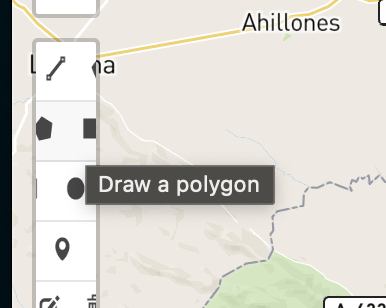

If `bypas = true` then Bypassed the selection with a fixed value

In [34]:
bbox_coords_wgs84 = get_bound_box(bypass = True)

In [13]:
resolution = 60
betsiboka_bbox = BBox(bbox=bbox_coords_wgs84, crs=CRS.WGS84)
betsiboka_size = bbox_to_dimensions(betsiboka_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {betsiboka_size} pixels")

Image shape at 60 m resolution: (508, 398) pixels


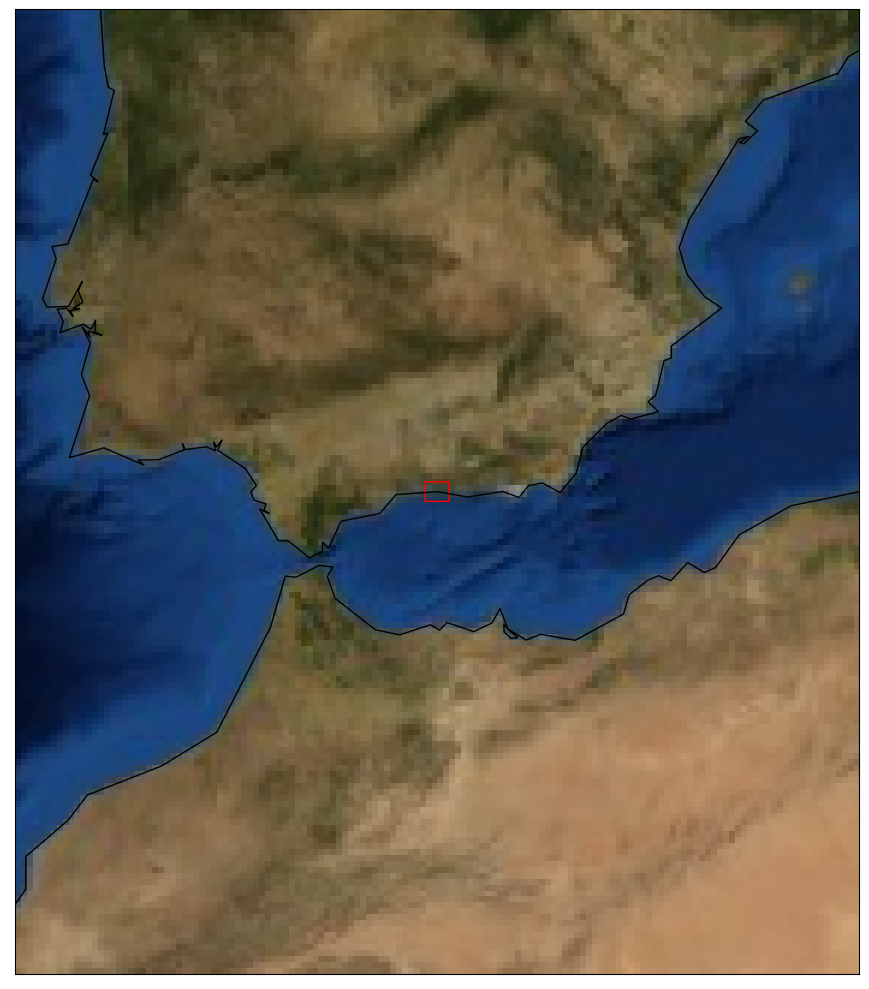

In [14]:
show_area(betsiboka_bbox.geometry)

## Check if size in px is higher of the limit 2500 per request. 

If is greater then we have to split the bbox

In [23]:
if (betsiboka_size[0] > 2500) or (betsiboka_size[1] > 2500):
    bbox_splitter = BBoxSplitter(
    [betsiboka_bbox.geometry], CRS.WGS84, (5, 4)
    )  # bounding box will be split into grid of 5x4 bounding boxes
    show_splitter(bbox_splitter, show_legend=True)
    bbox_list = bbox_splitter.get_bbox_list()
else:
    bbox_list = [betsiboka_bbox]

In [24]:
request = []
for bbox in bbox_list:
    request.append(generate_request(bbox))

In [25]:
true_color_imgs = []
for req in request:
    true_color_imgs.append(req.get_data())

## Check one image

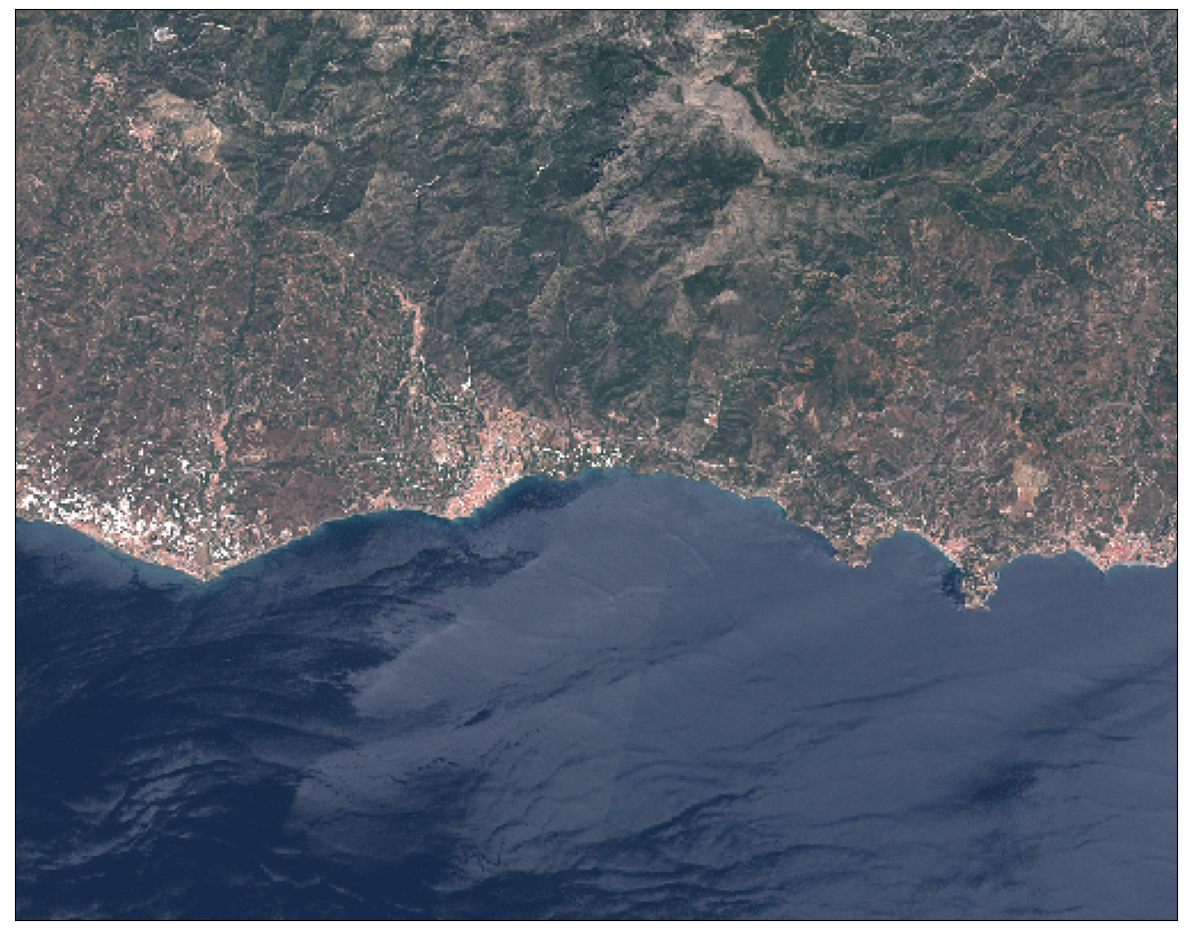

In [26]:
plot_image(true_color_imgs[0][0], factor= 3.5 / 255, clip_range=(0, 1))

## Save images into folder

Create path if not exist
Create image with the same color as the plot

In [27]:
import os
path = "images"
isExist = os.path.exists(path)
if not(isExist):
    os.makedirs("images")
name = "granada"
filepath = f"images/{name}"

In [28]:
factor = 3.5 / 255
clip = (0, 1)
i = 0
for img in true_color_imgs:
    print("saving" + filepath+str(i))
    save_image(filepath+str(i),img[0],factor,clip)
    i = i + 1

savingimages/granada0
